In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21
df['Mass_HI'] = 2.356E5 * F21 * (df.D75**2)

print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi', 'F21',
       'eF21', 'Mass_HI'],
      dtype='object', length=120)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21,Mass_HI
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,-34.024557,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557,0.00,4.729334,0.805837,4.537307e+09
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,-18.127026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,0.47,1.926637,0.134862,1.392470e+09
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,-34.620362,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362,0.00,3.400948,0.579492,5.648331e+09
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,-19.921429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,0.78,1.194538,0.203539,1.451933e+09
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,-18.364131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,0.31,4.541507,0.317899,3.863918e+09


In [4]:
dff = df[(df.elgWi>0)&(df.lgWmxi>0)].dropna()

In [5]:
def Chi2(theta):
    
    
    
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    
    slope = theta[3]
    zp    = theta[4]
    
    ###########################################################
    
    dff['logMs_op'] = (beta + alpha * dff.gi) - 0.4*dff.Mi_75
    dff['logMs_ir'] = gamma - 0.4*dff.M1_75
       
    dff['Mass_star_op'] = 10**dff.logMs_op
    dff['Mass_star_ir'] = 10**dff.logMs_ir
    
    dff['Mb_op'] = 1.33*dff['Mass_HI'] + dff['Mass_star_op']
    dff['Mb_ir'] = 1.33*dff['Mass_HI'] + dff['Mass_star_ir']
    
    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    
    dff['logMass_op'] = np.log10(dff.Mb_op.values)
    dff['logMass_ir'] = np.log10(dff.Mb_ir.values)
    
    dff['logWp_op'] = (dff.logMass_op-zp)/slope+2.5
    dff['logWp_ir'] = (dff.logMass_ir-zp)/slope+2.5
        
    dff['chi2_op'] = (logW-dff.logWp_op.values)**2/logWe**2
    dff['weight'] = 1./logWe**2
    dff['chi2_ir'] = (logW-dff.logWp_ir.values)**2/logWe**2
    
    op_ind = (df.Qs>2)
    Xi2_op = np.nansum(dff.chi2_op[op_ind].values)/np.nansum(dff.weight[op_ind].values)
    
    ir_ind = (df.Qw>2)
    Xi2_ir = np.nansum(dff.chi2_ir[ir_ind].values)/np.nansum(dff.weight[ir_ind].values)

    dff['chi2_cross'] = (dff.logWp_op.values-dff.logWp_ir.values)**2
    ind = (df.Qs>2) & (df.Qw>2)
    xi2_cross = dff.chi2_cross[ind].values
    N = len(xi2_cross)
    xi2_cross = np.nansum(xi2_cross)/N
    
    return Xi2_op+Xi2_ir+xi2_cross


def lnlike(theta):
    
    xi2 = Chi2(theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    if np.abs(theta[0])<10:
        if np.abs(theta[1])<10:
            if np.abs(theta[2])<10:
                if theta[3]>0 and theta[3]<20:   # slope
                    if theta[4]>0 and theta[4]<20: # zp
                        return 0

    return -np.inf


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [6]:
%%time

res = Chi2([0.3,0.1,10,3,20])
res

CPU times: user 18.4 ms, sys: 7.47 ms, total: 25.9 ms
Wall time: 21.9 ms


19.465705767656125

In [7]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 5, 32

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 2000)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value en

Execution time:
0:09:03.206055


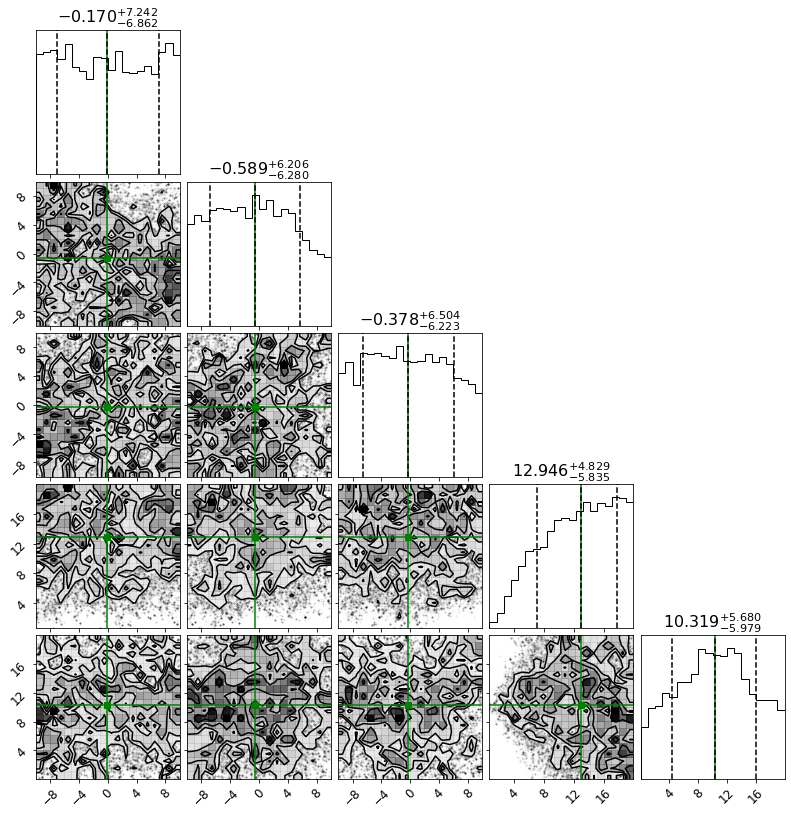

In [8]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))


samples_ = samples
# samples_ = samples_[np.where(samples_[:,0]>1.2)]

# samples_ = samples_[np.where(samples_[:,1]>4)]
# samples_ = samples_[np.where(samples_[:,2]>9)]
# samples_ = samples_[np.where(samples_[:,3]>9.2)]


# samples_[:,1] -= 0.4*4.58

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples_, 
                            [16, 50, 84],
                            axis=0)))

# labels = [r"$\alpha_0$", r"$\beta_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]
# labels = [r"$\beta_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]

truths=[t[0] for t in theta]
fig = corner.corner(samples_, truth_color='g',
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 16}, 
                    title_fmt=".3f")


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(20)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt) 

In [9]:
truths

[-0.16975306500128085,
 -0.5890653099611154,
 -0.37781114648268355,
 12.94635238031611,
 10.3185256978538]

(<AxesSubplot:label='990d2f4f-90a6-481b-b261-639a0041d1aa'>,
 <AxesSubplot:label='f1fbd860-5f15-433f-8153-5ecc5b23b4b0'>)

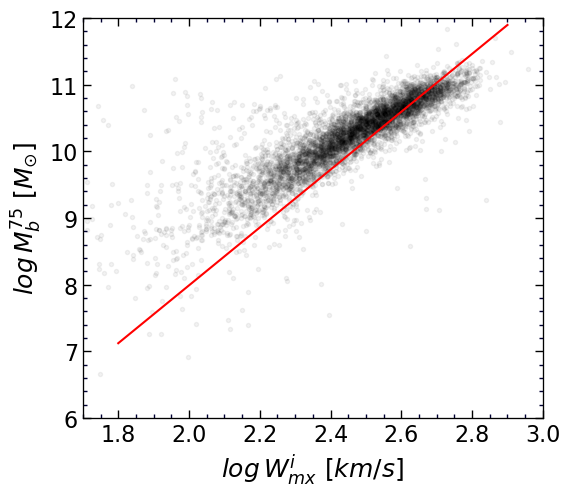

In [10]:
logMs = 2. - 0.4*df['M1_75']
df['Mass_star'] = 10**logMs
df['Mb'] = 1.33*df['Mass_HI'] + df['Mass_star']

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


X = df.lgWmxi.values
Y = np.log10(df.Mb.values)

ax.plot(X, Y, 'k.', alpha=0.05)

w = np.linspace(1.8,2.9,100)
# M = 4.378027433423001*(w-2.5) + 9.898532993058211
M = 4.340*(w-2.5) + 10.161

ax.plot(w, M, 'r-')


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (6,12))